In [2]:
from hmmlearn import hmm
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd

In [4]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20.7,8.27)})

In [5]:
import hmmlearn.hmm as hmm
import numpy as np

In [10]:
clean_data = '~/data/pdkit/GAIT_-_2018-06-14_13-50-58_-_d90b653403_-_13311.csv'

In [11]:
from pdkit.gait_time_series import GaitTimeSeries
from pdkit.gait_processor import GaitProcessor

Sampling rate is 499.6666666666667 Hz
Sampling rate is 499.6666666666667 Hz


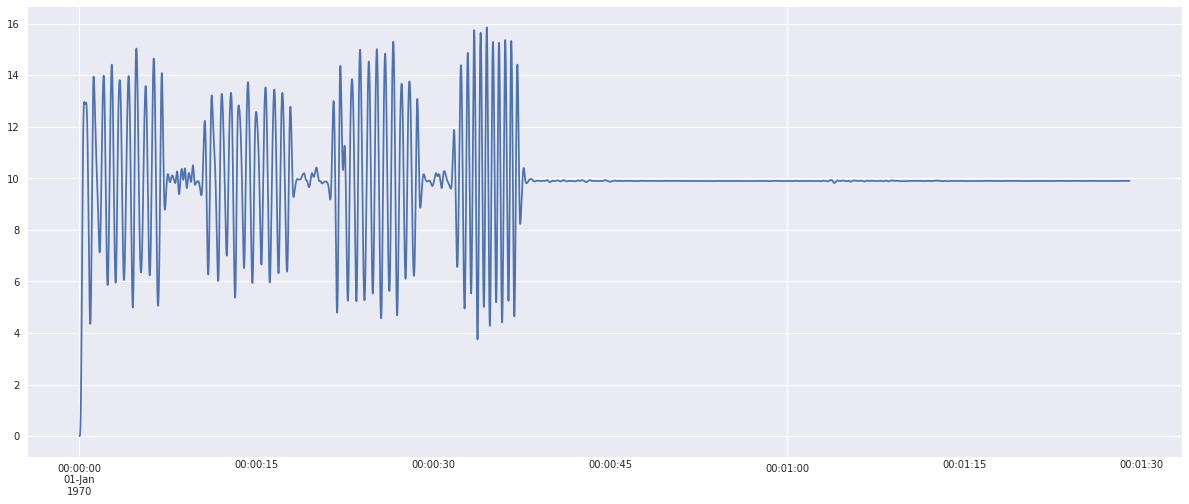

In [12]:
ts = GaitTimeSeries.load_data(clean_data, format_file='gait_gyro')
gp = GaitProcessor(sampling_frequency=500, filter_order=4)

r_ts = gp.resample_signal(ts)
fr_ts = gp.filter_data_frame(r_ts, centre=False)

fr_ts.mag_sum_acc.plot()

In [13]:
import scipy.signal as sig
from pdkit.utils import cluster_walk_turn, plot_walk_turn_clusters

In [14]:
d = fr_ts.mag_sum_acc.values

In [15]:
cls, pk, promi = cluster_walk_turn(d, window=False)

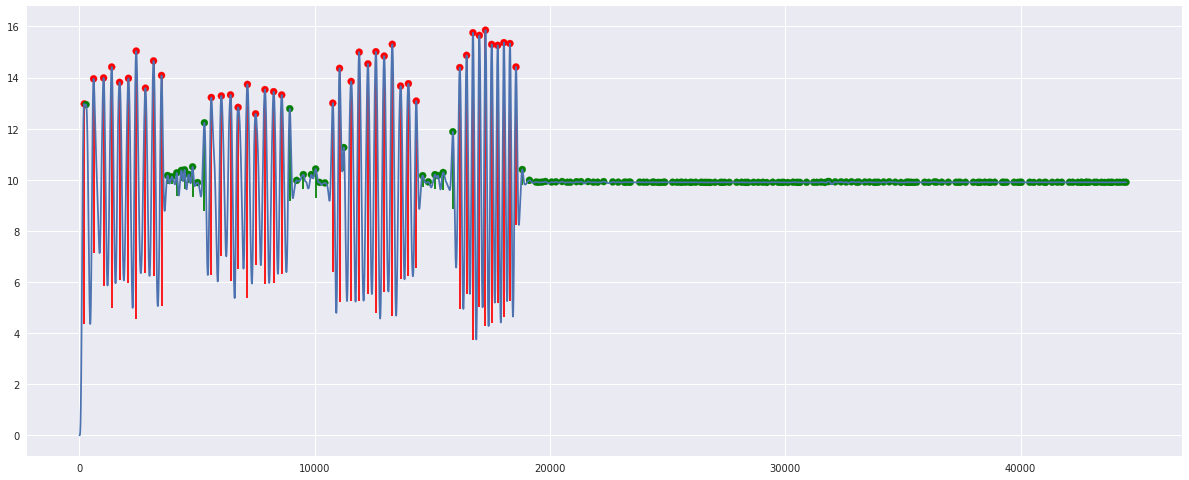

In [16]:
plot_walk_turn_clusters(d, window=False)

In [18]:
cls[65:] = 2

14.207673838294175 0.7833148733873372
10.58953495253397 0.7657622555805383
9.904763402440414 0.00010626227785020861


In [30]:
def plot_classes(data, cls):
    CLR = ['red', 'green', 'blue', 'yellow', 'magenta', 'orange', 'purple'] * 100
    peaks, _ = sig.find_peaks(data)
    
    colors = [CLR[i] for i in cls]
    plt.plot(data)
    plt.scatter(peaks, data[peaks], color=colors)
    plt.show()

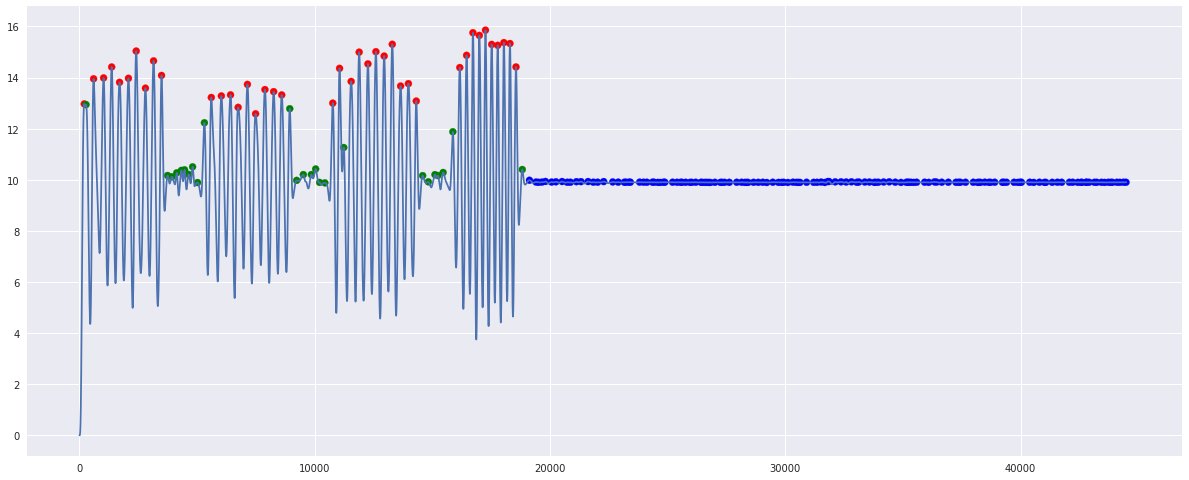

In [31]:
plot_classes(d, cls)

In [66]:
states = ['walk', 'turn', 'stand']
initial_state_distrib = [0.9, 0.05, 0.05]

observations = ['high', 'medium', 'small']

states_distrib = pd.Series(index=states, data=initial_state_distrib)
states_distrib

state_transitions_mat = [[0.8, 0.1, 0.1],
                         [0.1, 0.9, 0.0],
                         [0.0, 0.0, 1.0]]

transitions = pd.DataFrame(index=states, columns=states, data = state_transitions_mat)
transitions

emissions_mat = [[.9, .1, .0],
                 [.0, .9, .1],
                 [.0, .1, .9]]

emissions = pd.DataFrame(index=observations, columns=states, data= emissions_mat)
emissions
for i in range(3):
    clss = d[pk[np.where(cls == i)]]
    print(clss.mean(), clss.var())
mhmm = hmm.MultinomialHMM(n_components=3, n_iter=1000, algorithm='viterbi')
mhmm.startprob_ = np.array(states_distrib.values)
mhmm.transmat_ = np.array(transitions.values)
mhmm.emissionprob_ = np.array(emissions.values)

14.207673838294175 0.7833148733873372
10.58953495253397 0.7657622555805383
9.904763402440414 0.00010626227785020861


In [67]:
transitions

,walk,turn,stand
walk,0.8,0.1,0.1
turn,0.1,0.9,0.0
stand,0.0,0.0,1.0


In [68]:
emissions

,walk,turn,stand
high,0.9,0.1,0.0
medium,0.0,0.9,0.1
small,0.0,0.1,0.9


In [69]:
hmm_cls = mhmm.decode(cls.reshape(-1, 1))

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/hmmlearn/hmm.py:405: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/home/c/lab/envs/pdkit/lib/python3.6/site-packages/hmmlearn/base.py:452: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_), framelogprob)


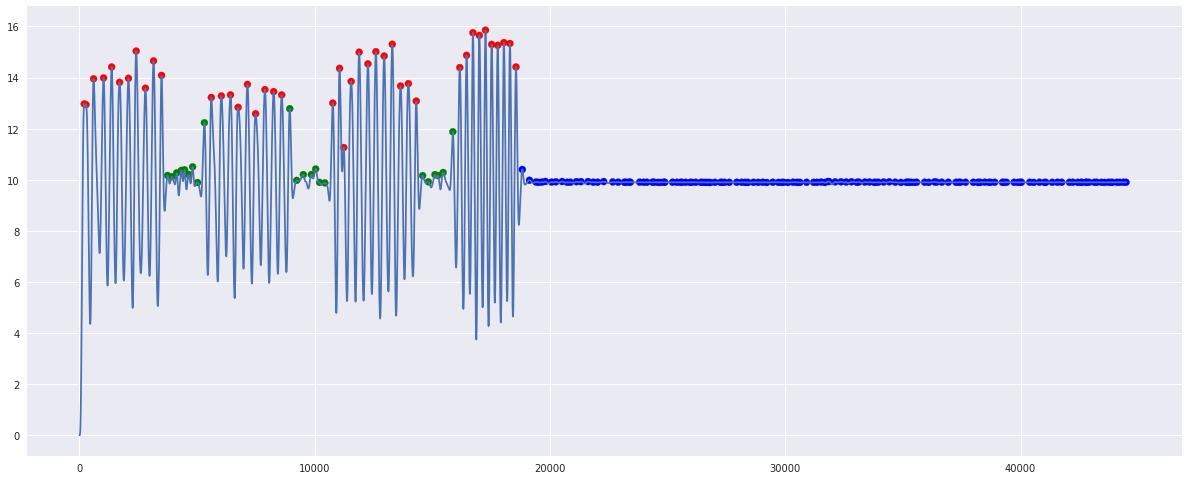

In [70]:
plot_classes(d, hmm_cls[1])

In [71]:
m_hmm = hmm.MultinomialHMM(n_components=3, n_iter=1000, algorithm='viterbi')

In [72]:
m_hmm.fit(cls.reshape(-1, 1))

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/home/c/lab/envs/pdkit/lib/python3.6/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),


MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=3,
        n_iter=1000, params='ste',
        random_state=<mtrand.RandomState object at 0x7ff99c12e240>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/hmmlearn/base.py:451: RuntimeWarning: divide by zero encountered in log
  n_samples, n_components, np.log(self.startprob_),


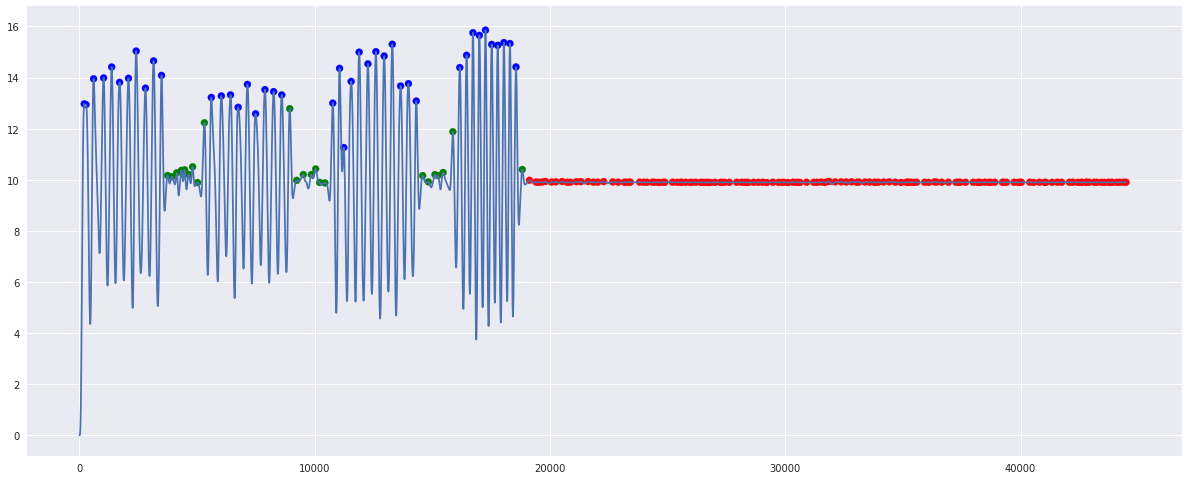

In [73]:
plot_classes(d, m_hmm.decode(cls.reshape(-1, 1))[1])

In [103]:
ghmm = hmm.GaussianHMM(n_components=3,
                       covariance_type='full')

ghmm.startprob_ = states_distrib.values
ghmm.transmat_ = transitions.values
#ghmm.emissionprob_ = emissions.values

In [108]:
means = []
varrs = []

for i in range(3):
    clss = d[pk[np.where(cls == i)]]
    means.append([clss.mean()])
    varrs.append([[clss.std()]])

In [109]:
means, varrs

([[14.207673838294175], [10.58953495253397], [9.904763402440414]],
 [[[0.8850507744685258]], [[0.8750784282454563]], [[0.010308359610054774]]])

In [110]:
ghmm.means_ = means
ghmm.covars_ = varrs

In [102]:
ghmm.fit(cls.reshape(-1, 1))

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/c/lab/envs/pdkit/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/c/lab/envs/pdkit/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/c/lab/envs/pdkit/lib/python3.6/site-package

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [116]:
ghmm.means_ = [ [0], [1], [2]]

In [122]:
ghmm.covars_ = [[[0.5]], [[0.03]], [[0.03]]]

In [123]:
ghmm.decode(cls.reshape(-1, 1))

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/c/lab/envs/pdkit/lib/python3.6/site-packages/hmmlearn/base.py:452: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_), framelogprob)


(87.29827361627285,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [ ]:
ghmm.

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/c/lab/envs/pdkit/lib/python3.6/site-packages/hmmlearn/base.py:452: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_), framelogprob)


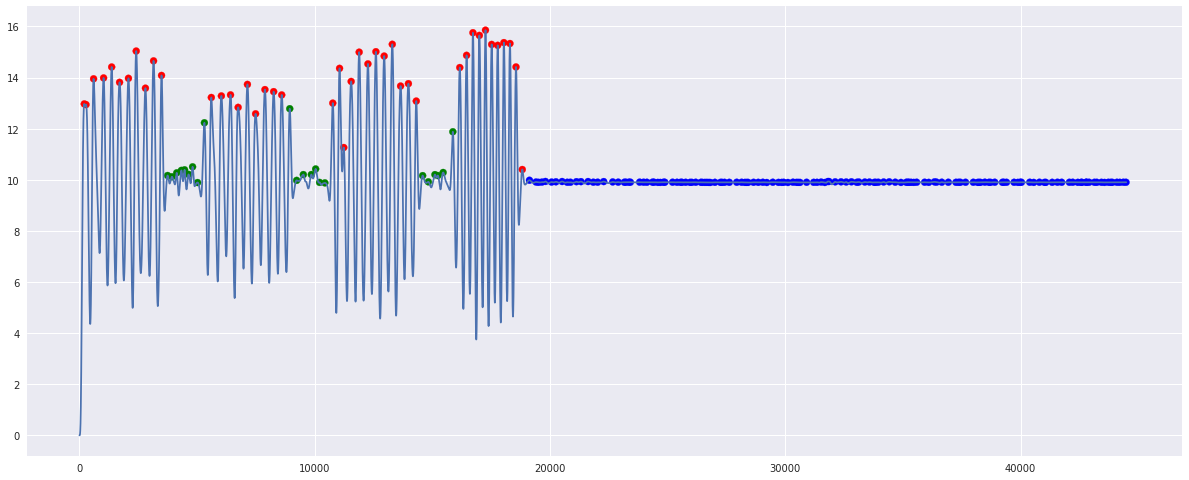

In [124]:
plot_classes(d, ghmm.decode(cls.reshape(-1, 1))[1])

In [514]:
n_clusters = 16
ac = cluster.AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='complete')

In [515]:
peaks, _ = sig.find_peaks(d)
prominences = sig.peak_prominences(d, peaks)[0]
clusters = ac.fit_predict(prominences.reshape(-1, 1))

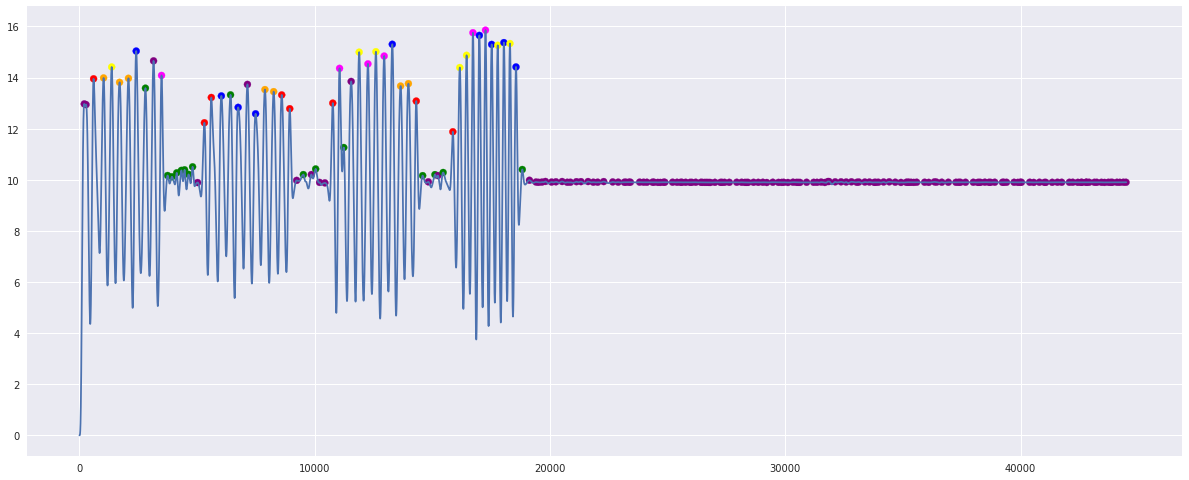

In [516]:
plot_classes(d, clusters)

In [517]:
means = [d[peaks[np.where(clusters == c)]].mean() for c in range(n_clusters)]

In [518]:
stand = np.argsort(means)[0]
turn = np.argsort(means)[1]
walk = np.argsort(means)[2:]

In [519]:
# give walking class 0
for w in walk:
    clusters[np.where(clusters == w)] = 1000

# give turning class 1
clusters[np.where(clusters == turn)] = 2000

# give standing class 2
clusters[np.where(clusters == stand)] = 3000

In [520]:
clusters[np.where(clusters == 1000)] = 0
clusters[np.where(clusters == 2000)] = 1
clusters[np.where(clusters == 3000)] = 2

In [521]:
clusters

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

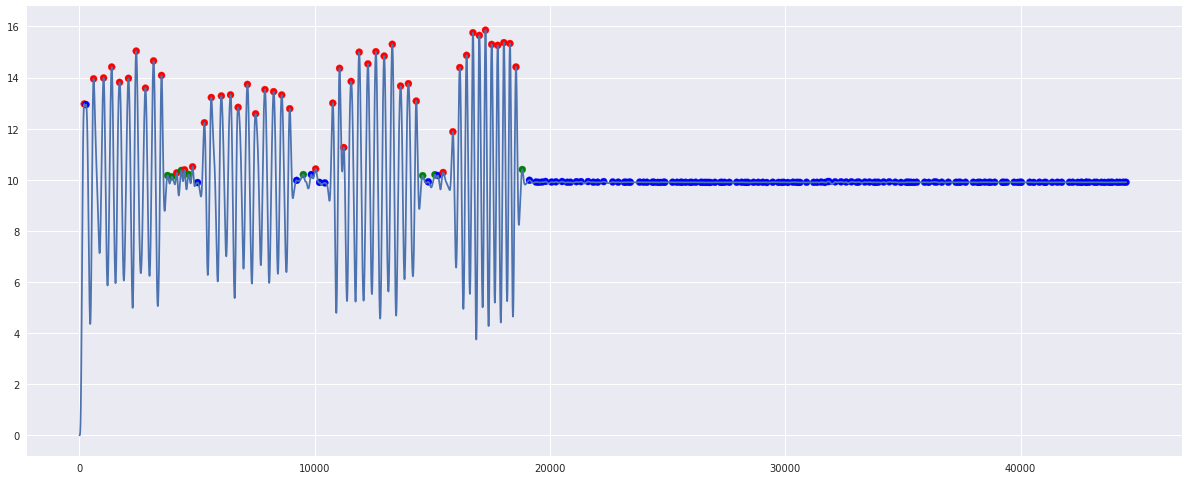

In [523]:
plot_classes(d, clusters)

In [524]:
hmm_cls_2 = mhmm.decode(clusters.reshape(-1, 1))

/opt/conda/lib/python3.6/site-packages/hmmlearn/hmm.py:405: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T


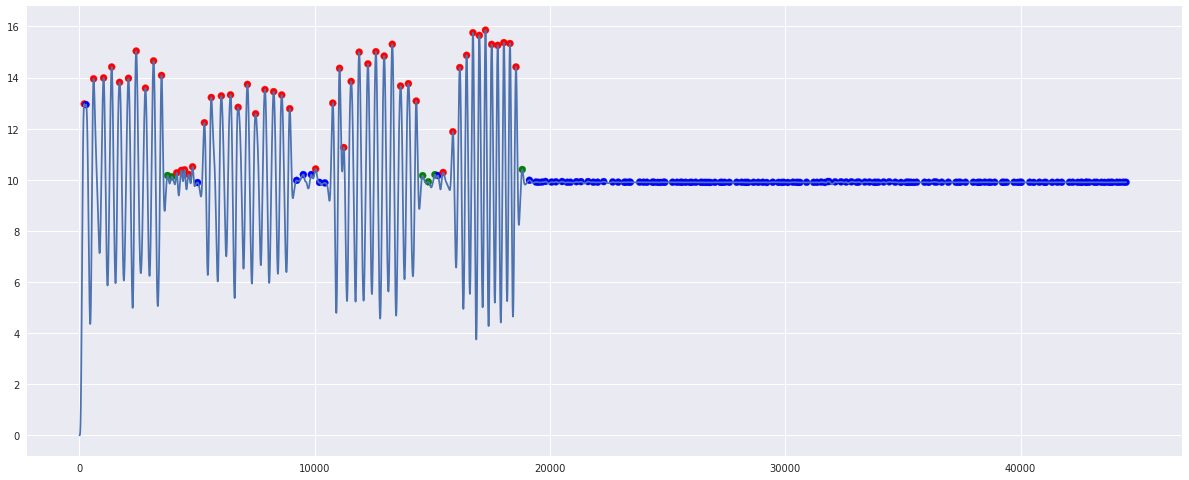

In [527]:
plot_classes(d, hmm_cls_2[1])